# Oxygen-limited growth analysis

Reproduces Fig. 4 and Fig. S4 of Zakhartsev et al. "SALARECON connects the Atlantic salmon genome to growth and feed efficiency" (2021).

In [1]:
import cobra
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from collections import defaultdict
from gprofiler import GProfiler
from itertools import combinations
from matplotlib import rcParams
from matplotlib.lines import Line2D
from os.path import join
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
from sklearn.cluster import AgglomerativeClustering

%matplotlib inline
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Arial'
rcParams['mathtext.it'] = 'Arial:italic'
rcParams['mathtext.bf'] = 'Arial:bold'
plot_dir = '../../figures'
data_path = '../../data'
model_path = f'{data_path}/models'
sasa_path = '../../salarecon.xml'

In [2]:
# Load SALARECON
model = cobra.io.read_sbml_model(sasa_path)
model

Using license file C:\Users\ovoy\gurobi.lic
Academic license - for non-commercial use only


<Model salarecon at 0x11e1860a5c0>

In [77]:
# Number of conditions and oxygen levels to sample
conditions = 1000
levels = 50

# Define essential amino acids and choline as biomass and energy precursors
precursors = [model.metabolites.get_by_id(x + '_e')
              for x in ['arg__L', 'his__L', 'ile__L', 'leu__L', 'lys__L', 'met__L', 'phe__L', 'thr__L', 'trp__L', 'val__L', 'chol']]

# Set boundary conditions
for r in model.boundary:
    # Turn off uptake of all metabolites except oxygen and phosphate
    r.lower_bound = -1000 if r.id in set('EX_' + x + '_e' for x in ['o2', 'pi']) else 0 
#     # Turn off secretion of all metabolites except CO2, ammonia, urea, and precursors
#     r.upper_bound = 1000 if r.id in set('EX_' + x + '_e' for x in ['co2', 'nh4', 'urea']) or r.reactants[0] in precursors else 0
    r.upper_bound = 1000

# Turn off all sink and demand reactions
for r in model.sinks:
    r.bounds = 0, 0
for r in model.demands:
    r.bounds = 0, 0
    
model.reactions.EX_hco3_e.bounds = 0, 0

# Create feed reaction
feed = cobra.Reaction('feed')
feed.bounds = -1000, 0
model.add_reaction(feed)

# Create data frames for bounds, conditions, growth predictions, and pFBA solutions
bound_df = pd.DataFrame()
cond_df = pd.DataFrame()
pred_df = pd.DataFrame()
sol_df = pd.DataFrame()

# Numerical tolerance
tol = 1e-6

# Reactions for which bounds should be randomly sampled
rand_reactions = [r for r in model.reactions if not r.boundary and not 'feed' in r.id.lower() and not 'biomass' in r.id.lower()]

i = 0
while i < conditions:
    print()
    print(i)
    
#     # Uniform random sampling of bounds for enzymatic reactions (preserving reversibility)
#     for r in rand_reactions:
#         r.bounds = np.random.uniform(1, 100, 2) * np.sign(r.bounds)

    # Random sampling of bounds for enzymatic reactions (preserving reversibility)
    for r in rand_reactions:
#         r.bounds = np.random.uniform(1, 100, 2) * np.sign(r.bounds)
        r.bounds = np.random.lognormal(0, 2, 2) * np.sign(r.bounds)
    
    # Random sampling of feed coefficients between 1 and 100
    d = defaultdict(list)
    for m in precursors:
        c = np.random.uniform(1, 100)
#         c = np.random.lognormal(1, 2)
        feed.add_metabolites({m: -c})
        d['i'].append(i)
        d['met'].append(m.id[:-2])
        d['c'].append(c)
    
    # Normalize feed uptake to 1 g / gDW
    factor = 1e3 / np.sum([m.formula_weight * -c for m, c in feed.metabolites.items()])
    new_m = {m: c * factor for m, c in feed.metabolites.items()}
    feed.subtract_metabolites(feed.metabolites)
    feed.add_metabolites(new_m)

    # Get oxygen uptake and biomass reactions
    o2 = model.reactions.EX_o2_e
    bm = model.reactions.Biomass

    # Compute maximal growth rate without oxygen limitation
    s = model.optimize()
    growth_max = s[bm.id]
    print(growth_max)
    
    # Try again if growth is not possible
    if growth_max < tol:
        continue

    # Compute minimal oxygen uptake rate at maximal growth rate
    bm.lower_bound = growth_max
    model.objective = o2
    s = model.optimize()
    o2_max = -s[o2.id]
    print(o2_max)
    
    # Set growth maximization as objective
    bm.lower_bound = 0
    model.objective = bm
    model.objective_direction = 'max'

    # Try again if oxygen is not required for growth
    if o2_max < tol:
        continue
    
    # Predict maximal growth rates for linearly spaced oxygen uptake rates
#     xmin = 0
#     xmax = o2_max
#     x = np.linspace(xmin, xmax, levels)

    # Predict maximal growth rates for logarithmically spaced oxygen uptake rates
    xmin = np.log10(o2_max / 1e3)
    xmax = np.log10(o2_max)
    x = [0]
    x.extend(np.logspace(xmin, xmax, levels - 1))

    y = []
    for lb in x:
        if lb <= o2_max:
            o2.lower_bound = -lb
            s = cobra.flux_analysis.pfba(model)
            y.append(s['Biomass'])
            sol_df = sol_df.append(s.fluxes).reset_index(drop=True)
        else:
            y.append(growth_max)
            sol_df = sol_df.append(sol_df.iloc[-1, :]).reset_index(drop=True)
    
    # Save predictions
    df = pd.DataFrame({'o2_in': x, 'growth': y, 'i': i, 'j': np.arange(levels)})
    df['o2_in_rel'] = df.o2_in / o2_max
    df['growth_rel'] = df.growth / growth_max
    pred_df = pred_df.append(df, ignore_index=True)
    
    # Save bounds
    x, lb, ub = list(zip(*[(r.id, *r.bounds) for r in rand_reactions]))
    df = pd.DataFrame({'reaction': x, 'lb': lb, 'ub': ub, 'i': i})
    bound_df = bound_df.append(df, ignore_index=True)
    
    # Save sampled conditions
    cond_df = cond_df.append(pd.DataFrame(d))
    
    # Reset feed reaction by removing metabolites
    feed.subtract_metabolites(feed.metabolites)
    
    # Reset oxygen uptake rate
    o2.lower_bound = -1000
    
    i += 1

pred_df = pred_df.round(5)

bound_df.to_csv(f'{data_path}/o2_bounds.csv')
cond_df.to_csv(f'{data_path}/o2_conditions.csv')
pred_df.to_csv(f'{data_path}/o2_growth.csv')
sol_df.to_csv(f'{data_path}/o2_solutions.csv')

pred_df.head()


0
0.007812697004420058
0.07878521115762702


TypeError: Cannot interpret '<attribute 'dtype' of 'numpy.generic' objects>' as a data type

In [3]:
# Load oxygen-limited growth predictions
bound_df = pd.read_csv(f'{data_path}/o2_bounds.csv', index_col=0)
cond_df = pd.read_csv(f'{data_path}/o2_conditions.csv', index_col=0)
pred_df = pd.read_csv(f'{data_path}/o2_growth.csv', index_col=0)
sol_df = pd.read_csv(f'{data_path}/o2_solutions.csv', index_col=0)

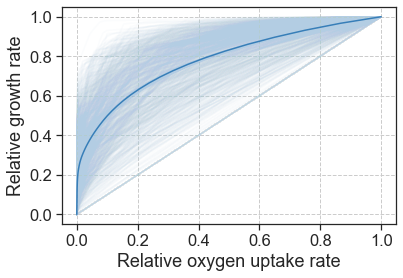

In [3]:
# Plot relative oxygen-limited growth predictions
sns.set(font_scale=1.5, style='ticks')

f = plt.figure()

for i, df in pred_df.groupby('i'):
    plt.plot(df.o2_in_rel, df.growth_rel, c='#b3cde3', alpha=5e-2)

df = pred_df
ax = sns.lineplot(x=df.o2_in_rel, y=df.growth_rel, ci=95, color='#377eb8')
plt.xlabel('Relative oxygen uptake rate')
plt.ylabel('Relative growth rate')
plt.grid(True, ls='--')

f.set_size_inches(6, 4)
f.savefig(join(plot_dir, 'o2_uptake_growth.svg'), bbox_inches='tight')

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


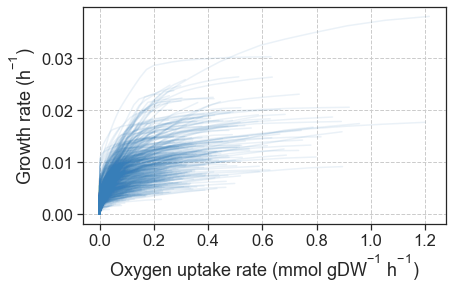

In [4]:
# Plot absolute oxygen-limited growth predictions
sns.set(font_scale=1.5, style='ticks')

f = plt.figure()

for i, df in pred_df.groupby('i'):
    plt.plot(df.o2_in, df.growth, c='#377eb8', alpha=1e-1)

df = pred_df
# ax = sns.lineplot(x=df.o2_in, y=df.growth, ci=0.999, c='#377eb8')
plt.xlabel('Oxygen uptake rate (mmol gDW$^{-1}$ h$^{-1}$)')
plt.ylabel('Growth rate (h$^{-1}$)')
plt.grid(True, ls='--')
# plt.xlim(0, 60)

f.set_size_inches(6.5, 4)
f.savefig(join(plot_dir, 'o2_uptake_growth_abs.svg'), bbox_inches='tight')

In [389]:
# Load experimental data

df1 = pd.read_csv(f'{data_path}/thorarensen2011.csv')
df1.o2 /= 100
df1.growth /= 100

df2 = pd.read_csv(f'{data_path}/bergheim2014.csv')
df2.o2 /= df2.o2.max()
df2.growth /= df2.growth.max()

df3 = pd.DataFrame({'o2': [0.93, 1.25, 1.45], 'growth': [0.66, 0.64, 0.75], 'source': ['hosfeld2010'] * 3})
df3.growth /= df3.growth.max()

exp_df = df1.append(df2).append(df3).sort_values(by='source')

exp_df

o2    growth        source
0  0.647581  0.865020      berg1993
1  0.697514  0.877919      berg1993
2  0.905412  0.961451      berg1993
3  0.959367  1.002020      berg1993
4  1.180608  0.923885      berg1993
6  1.280396  0.964576      berg1993
6  1.000000  1.000000  bergheim2002
5  0.857175  0.888869  bergheim2002
4  0.811528  0.746325  bergheim2002
3  0.678607  0.669414  bergheim2002
2  0.670979  0.764801  bergheim2002
0  0.554158  0.525703  bergheim2002
1  0.539379  0.634501  bergheim2002
8  1.106451  0.761985   hosfeld2008
7  0.929381  0.759387   hosfeld2008
5  1.223947  1.002723   hosfeld2008
1  1.250000  0.853333   hosfeld2010
0  0.930000  0.880000   hosfeld2010
2  1.450000  1.000000   hosfeld2010

Metabolic
0.5410171843859517
[0.31491605 1.36688236]
[0.10394703 0.15246205]

Logistic
0.5667174626898757
[0.11023152 3.43565184]
[0.15519144 0.90496868]

Monod
0.5966540446684692
[0.45853965 0.06000545]
[0.03894524 0.01727571]



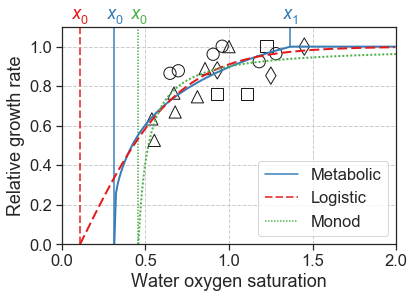

In [394]:
# Plot model fits to experimental data

sns.set(style='ticks', font_scale=1.5)

# Interpolate metabolic model predictions
df = pred_df
mp = interp1d(sorted(set(df.o2_in_rel)), df.groupby('o2_in_rel').growth_rel.mean(), fill_value=(0, 1), bounds_error=False)

def f1(x, x0, xmax):
    """Metabolic model with linear relationship between uptake rate and saturation."""
    return mp((x - x0) / (xmax - x0))

def f2(x, x0, km):
    """Metabolic model with Michaelis-Menten relationship between uptake rate and saturation."""
    return mp[-1]((x - x0) / (km + x - x0))
                       
def f3(x, x0, slope):
    """Logistic function with left asymptote -1 and right asymptote 1."""
    return -1 + 2 / (1 + np.exp(slope * (x0 - x)))

def f4(x, x0, k):
    """Monod function with constant offset."""
    return (x - x0) / (k + x - x0)

models = (f1, f3, f4)
p0 = ((0.5, 1), (0.5, 5), (0.5, 0.05))

f = plt.figure()

x = np.array(exp_df.o2)
y = np.array(exp_df.growth)

xlim = 0, 2
ylim = 0, 1.1

palette = ['#377eb8', '#e41a1c', '#4daf4a']
markers = ['o', '^', 's', 'd'][:len(set(exp_df.source))]
dashes = [(0, ()), (0, (5, 2)), (0, (1, 1))]
labels = ['Metabolic', 'Logistic', 'Monod']
labels.extend(['Berg (1993)', 'Bergheim (2002)', 'Hosfeld (2008)', 'Hosfeld (2010)'][:len(set(exp_df.source))])

ax = sns.scatterplot(x='o2', y='growth', data=exp_df, s=150, linewidth=1, 
                     edgecolor='k', style='source', markers=markers, facecolors='none', zorder=1)

d1 = defaultdict(list)
d2 = defaultdict(list)

for i, m in enumerate(models):
    # Fit model
    popt, pcov = curve_fit(m, x, y, p0=p0[i], maxfev=int(1e4))
    
    # Get parameter values and standard errors
    pstd = np.sqrt(np.diag(pcov))
    x0 = popt[0]
    x0_sd = pstd[0]
    
    if i == 0:
        xmax = popt[1]
        xmax_sd = pstd[1]
    else:
        xmax = xmax_sd = np.nan
        
    if i == 1:
        k = popt[1]
        k_sd = pstd[1]
    else:
        k = k_sd = np.nan
        
    if i == 2:
        ks = popt[1]
        ks_sd = pstd[1]
    else:
        ks = ks_sd = np.nan
        
    # Predict with fitted model
    xfit = np.arange(x0, xlim[1], 1e-2)
    yfit = m(xfit, *popt)
    
    # Calculate coefficient of determination
    ssr = np.sum((y - m(x, *popt)) ** 2)
    sst = np.sum((y - np.mean(y)) ** 2)
    r2 = 1 - ssr / sst
    
    print(labels[i])
    print(r2)
    print(popt)
    print(pstd)
    print()
    
    # Save fit and parameters
    d1['xfit'].extend(xfit)
    d1['yfit'].extend(yfit)
    d1['i'].extend([i] * len(xfit))
    
    d2['i'].extend([i] * 5)
    d2['param'].extend(['r2', 'x0', 'xmax', 'k', 'ks'])
    d2['value'].extend([r2, x0, xmax, k, ks])
    d2['sd'].extend([np.nan, x0_sd, xmax_sd, k_sd, ks_sd])
    
    # Indicate parameters along horizontal axis
    dy = 0.04
    plt.plot([x0, x0], ylim, c=palette[i], ls=dashes[i], zorder=1, alpha=1)
    plt.text(x0, ylim[1] + dy, '$x_0$', c=palette[i], ha='center')
    if i == 0:
        plt.plot([xmax, xmax], [1, ylim[1]], c=palette[i], ls=dashes[i], zorder=1, alpha=1)
        plt.text(xmax, ylim[1] + dy, '$x_1$', c=palette[i], ha='center')

# Create fit and parameter data frames
fit_df = pd.DataFrame(d1)
param_df = pd.DataFrame(d2)

# Plot fits
ax = sns.lineplot(x='xfit', y='yfit', hue='i', style='i', data=fit_df, linewidth=2, palette=palette, dashes=[d[1] for d in dashes], ax=ax)

plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel('Water oxygen saturation')
plt.ylabel('Relative growth rate')
plt.grid(True, ls='--')

h, l = ax.get_legend_handles_labels()
h = h[:3]
# for i, marker in enumerate(markers):
#     h[-len(markers) + i] = Line2D([0], [0], marker=marker, color='k', markerfacecolor='none', markersize=10, linewidth=0)
plt.legend(h, labels, loc='lower right', ncol=1).set_visible(True)

f.set_size_inches(6, 4)
f.savefig(join(plot_dir, 'o2_growth_fits.svg'), bbox_inches='tight')

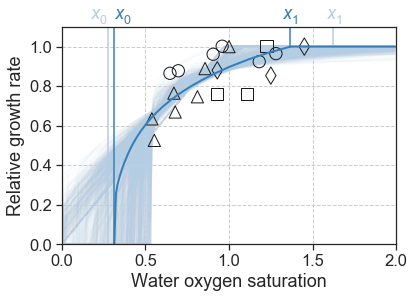

In [395]:
# Add individual metabolic model fits for each condition

m = f1
p0 = (0.5, 1)
bounds = (0, np.inf)

x = np.array(exp_df.o2)
y = np.array(exp_df.growth)

d1 = defaultdict(list)
d2 = defaultdict(list)

for i, df in pred_df.groupby('i'):
    # Interpolate metabolic model predictions
    mp = interp1d(sorted(set(df.o2_in_rel)), df.groupby('o2_in_rel').growth_rel.mean(), fill_value=(0, 1), bounds_error=False)
    
    # Fit model
    popt, pcov = curve_fit(m, x, y, p0=p0, maxfev=int(1e4), bounds=bounds)
    
    pstd = np.sqrt(np.diag(pcov))
    x0 = popt[0]
    x0_sd = pstd[0]
    
    xmax = popt[1]
    xmax_sd = pstd[1]
        
    # Predict with fitted model
    xfit = np.arange(0, xlim[1], 1e-2)
    yfit = m(xfit, *popt)
    
    # Calculate coefficient of determination
    ssr = np.sum((y - m(x, *popt)) ** 2)
    sst = np.sum((y - np.mean(y)) ** 2)
    r2 = 1 - ssr / sst
    
    # Save fit and parameters
    d1['xfit'].extend(xfit)
    d1['yfit'].extend(yfit)
    d1['i'].extend([i] * len(xfit))
    
    d2['i'].extend([i] * 3)
    d2['param'].extend(['r2', 'x0', 'xmax'])
    d2['value'].extend([r2, x0, xmax])
    d2['sd'].extend([np.nan, x0_sd, xmax_sd])
    
ind_fit_df = pd.DataFrame(d1)
ind_param_df = pd.DataFrame(d2)

# Add individual metabolic fits to figure with all models
for i, df in ind_fit_df.groupby('i'):
    ax.plot(df.xfit, df.yfit, c='#b3cde3', alpha=5e-2, zorder=0)

dy = 0.04
df = param_df
x0 = df[(df.i == 0) & (df.param == 'x0')].value.iloc[0]
xmax = df[(df.i == 0) & (df.param == 'xmax')].value.iloc[0]
ax.plot([x0, x0], ylim, c=palette[0], zorder=0, alpha=1)
ax.text(x0, ylim[1] + dy, '$x_0$', c=palette[0], ha='center')
ax.plot([xmax, xmax], [1, ylim[1]], c=palette[0], zorder=0, alpha=1)
ax.text(xmax, ylim[1] + dy, '$x_1$', c=palette[0], ha='center')

f.savefig(join(plot_dir, 'o2_growth_fits_all.svg'), bbox_inches='tight')

# Plot mean and individual metabolic fits
f = plt.figure()

ax = sns.scatterplot(x='o2', y='growth', data=exp_df, s=150, linewidth=1, 
                     edgecolor='k', style='source', markers=markers, facecolors='none', zorder=1)

ax = sns.lineplot(x='xfit', y='yfit', data=fit_df[fit_df.i == 0], linewidth=2, color=palette[0])

for i, df in ind_fit_df.groupby('i'):
    ax.plot(df.xfit, df.yfit, c='#b3cde3', alpha=5e-2, zorder=0)

plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel('Water oxygen saturation')
plt.ylabel('Relative growth rate')
plt.grid(True, ls='--')

dy = 0.04
df = param_df
x0 = df[(df.i == 0) & (df.param == 'x0')].value.iloc[0]
xmax = df[(df.i == 0) & (df.param == 'xmax')].value.iloc[0]
plt.plot([x0, x0], ylim, c=palette[0], zorder=1, alpha=1)
plt.text(x0, ylim[1] + dy, '$x_0$', c=palette[0], ha='left')
plt.plot([xmax, xmax], [1, ylim[1]], c=palette[0], zorder=1, alpha=1)
plt.text(xmax, ylim[1] + dy, '$x_1$', c=palette[0], ha='center')

gb = ind_param_df.groupby('param').value
df = pd.DataFrame()
df['value'] = gb.mean()
df['sd'] = gb.std() / np.sqrt(len(set(ind_param_df.i)))
df = df.reset_index()

x0 = df[df.param == 'x0'].value.iloc[0]
xmax = df[df.param == 'xmax'].value.iloc[0]
plt.plot([x0, x0], ylim, c='#b3cde3', zorder=1, alpha=1)
plt.text(x0, ylim[1] + dy, '$x_0$', c='#b3cde3', ha='right')
plt.plot([xmax, xmax], [1, ylim[1]], c='#b3cde3', zorder=1, alpha=1)
plt.text(xmax, ylim[1] + dy, '$x_1$', c='#b3cde3', ha='center')

plt.legend().set_visible(False)

f.set_size_inches(6, 4)
f.savefig(join(plot_dir, 'o2_growth_fits_all_metabolic.svg'), bbox_inches='tight')

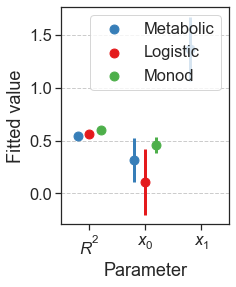

In [367]:
# Plot parameter estimates

sns.set(style='ticks', font_scale=1.5)
f = plt.figure()

n = len(set(param_df.param))
n = 3

dx = np.array([-1, 0, 1]) * 0.2
labels = ['Metabolic', 'Logistic', 'Monod']

for i, df in param_df.groupby('i'):
    df = df.iloc[:n]
    plt.scatter(x=np.arange(n) + dx[i], y=df.value, c=palette[i], s=80, label=labels[i])
    plt.errorbar(x=np.arange(n) + dx[i], y=df.value, yerr=2 * df.sd, fmt='none', marker='o', c=palette[i], lw=3)

ax = plt.gca()
# plt.title('$x_0$')
plt.xlim(-0.5, n - 0.5)
# plt.ylim(0, 1.5)
plt.xlabel('Parameter')
plt.ylabel('Fitted value')
plt.xticks(range(n))
# ax.set_xticklabels(labels, rotation=90)
ax.set_xticklabels(['$R^2$', '$x_0$', '$x_1$'])
plt.grid(True, ls='--', axis='y')
plt.legend().set_visible(True)

f.set_size_inches(n, 4)
f.savefig(join(plot_dir, 'o2_growth_param.svg'), bbox_inches='tight')

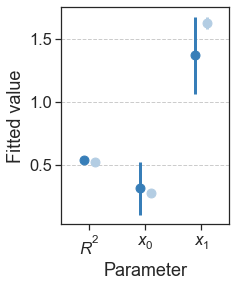

In [368]:
# Plot metabolic parameter estimates (mean and individual)
sns.set(style='ticks', font_scale=1.5)
f = plt.figure()

n = 3
dx = 0.1

df = param_df
df = df[df.i == 0][:n]

plt.scatter(x=np.arange(n) - dx, y=df.value, c=palette[0], s=80, label='Mean')
plt.errorbar(x=np.arange(n) - dx, y=df.value, yerr=2 * df.sd, fmt='none', marker='o', c=palette[0], lw=3)

gb = ind_param_df.groupby('param').value
df = pd.DataFrame()
df['value'] = gb.mean()
df['sd'] = gb.std() / np.sqrt(len(set(ind_param_df.i)))
df = df.reset_index()

plt.scatter(x=np.arange(n) + dx, y=df.value, c='#b3cde3', s=80, label='Individual')
plt.errorbar(x=np.arange(n) + dx, y=df.value, yerr=2 * df.sd, fmt='none', marker='o', c='#b3cde3', lw=3)

ax = plt.gca()
# plt.title('$x_0$')
plt.xlim(-0.5, n - 0.5)
# plt.ylim(0, 1.5)
plt.xlabel('Parameter')
plt.ylabel('Fitted value')
plt.xticks(range(n))
# ax.set_xticklabels(labels, rotation=90)
ax.set_xticklabels(['$R^2$', '$x_0$', '$x_1$'])
plt.grid(True, ls='--', axis='y')
plt.legend(loc='upper left').set_visible(False)

f.set_size_inches(n, 4)
f.savefig(join(plot_dir, 'o2_growth_param_metabolic.svg'), bbox_inches='tight')

In [4]:
# Normalize each flux by dividing its absolute value by its maximal value in each condition (takes some time)
sol_norm_df = sol_df.groupby(pred_df.i).transform(lambda x: x / x.abs().max()).fillna(0).abs()
sol_norm_df.to_csv(f'{data_path}/sol_norm_df.csv')

0         1         2         3         4         5         6      \
1PPDCRp      0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2AMADPTm     0.0  0.000000  0.000000  0.049808  0.000000  0.000000  0.000000   
2MCITt       0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2OBUTtm      0.0  0.000516  0.000595  0.000688  0.000794  0.000917  0.001059   
2OXOADOXm    0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...          ...       ...       ...       ...       ...       ...       ...   
r2009        0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
r2011        0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
r2015        0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
r2016        0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
r2539        0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

              7         8         9      ...     49990     49991     49992  \
1PPDCRp    0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
2AMADPTm   0.000000  0.000000  0.000000  ...  1.000000  1.000000  1.000000   
2MCITt     0.000000  0.000000  0.000000  ...  0.716975  0.732243  0.808758   
2OBUTtm    0.001223  0.001412  0.001631  ...  1.000000  1.000000  1.000000   
2OXOADOXm  0.000000  0.000000  0.000000  ...  0.696070  0.858305  1.000000   
...             ...       ...       ...  ...       ...       ...       ...   
r2009      0.000000  0.000000  0.000000  ...  0.425820  0.000000  0.000000   
r2011      0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
r2015      0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.051949   
r2016      0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
r2539      0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   

              49993     49994     49995     49996     49997     49998  \
1PPDCRp    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2AMADPTm   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2MCITt     0.622361  0.570324  0.601906  0.779329  0.907516  1.000000   
2OBUTtm    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2OXOADOXm  0.853840  0.688085  0.641172  0.895564  0.864863  0.987441   
...             ...       ...       ...       ...       ...       ...   
r2009      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
r2011      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
r2015      0.372888  0.653264  0.847232  0.833194  0.734899  1.000000   
r2016      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
r2539      0.000000  0.078214  0.609664  0.912894  1.000000  0.273320   

              49999  
1PPDCRp    0.000000  
2AMADPTm   1.000000  
2MCITt     0.833464  
2OBUTtm    0.827676  
2OXOADOXm  0.798535  
...             ...  
r2009      0.000000  
r2011      0.000000  
r2015      0.950049  
r2016      0.000000  
r2539      0.539897  

[719 rows x 50000 columns]

In [3]:
sol_norm_df = pd.read_csv(f'{data_path}/sol_norm_df.csv', index_col=0)
sol_norm_df

0         1         2         3         4         5         6  \
1PPDCRp    0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2AMADPTm   0.0  0.000000  0.000000  0.049808  0.000000  0.000000  0.000000   
2MCITt     0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2OBUTtm    0.0  0.000516  0.000595  0.000688  0.000794  0.000917  0.001059   
2OXOADOXm  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...        ...       ...       ...       ...       ...       ...       ...   
r2009      0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
r2011      0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
r2015      0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
r2016      0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
r2539      0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

                  7         8         9  ...     49990     49991     49992  \
1PPDCRp    0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
2AMADPTm   0.000000  0.000000  0.000000  ...  1.000000  1.000000  1.000000   
2MCITt     0.000000  0.000000  0.000000  ...  0.716975  0.732243  0.808758   
2OBUTtm    0.001223  0.001412  0.001631  ...  1.000000  1.000000  1.000000   
2OXOADOXm  0.000000  0.000000  0.000000  ...  0.696070  0.858305  1.000000   
...             ...       ...       ...  ...       ...       ...       ...   
r2009      0.000000  0.000000  0.000000  ...  0.425820  0.000000  0.000000   
r2011      0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
r2015      0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.051949   
r2016      0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
r2539      0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   

              49993     49994     49995     49996     49997     49998  \
1PPDCRp    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2AMADPTm   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2MCITt     0.622361  0.570324  0.601906  0.779329  0.907516  1.000000   
2OBUTtm    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2OXOADOXm  0.853840  0.688085  0.641172  0.895564  0.864863  0.987441   
...             ...       ...       ...       ...       ...       ...   
r2009      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
r2011      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
r2015      0.372888  0.653264  0.847232  0.833194  0.734899  1.000000   
r2016      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
r2539      0.000000  0.078214  0.609664  0.912894  1.000000  0.273320   

              49999  
1PPDCRp    0.000000  
2AMADPTm   1.000000  
2MCITt     0.833464  
2OBUTtm    0.827676  
2OXOADOXm  0.798535  
...             ...  
r2009      0.000000  
r2011      0.000000  
r2015      0.950049  
r2016      0.000000  
r2539      0.539897  

[719 rows x 50000 columns]

In [4]:
# Melt data
df = sol_norm_df
melt_df = df.T.melt(var_name='reaction', value_name='flux_rel')
melt_df['o2_in_rel'] = pd.concat([pred_df.o2_in_rel] * df.shape[0]).values

# tol = 1e-6
# gb = melt_df.groupby(['o2_in_rel', 'reaction'])
# s = (gb.flux_rel.mean() > tol).reset_index().groupby('reaction').flux_rel.any() & (gb.flux_rel.mean() < -tol).reset_index().groupby('reaction').flux_rel.any()
# x = set(s[~s].index)
# df.loc[x] = df.loc[x].abs()
# melt_df.loc[melt_df.reaction.isin(x), 'flux_rel'] = melt_df.loc[melt_df.reaction.isin(x)].flux_rel.abs()

melt_df

reaction  flux_rel  o2_in_rel
0         1PPDCRp  0.000000    0.00000
1         1PPDCRp  0.000000    0.00100
2         1PPDCRp  0.000000    0.00115
3         1PPDCRp  0.000000    0.00133
4         1PPDCRp  0.000000    0.00154
...           ...       ...        ...
35949995    r2539  0.609664    0.56234
35949996    r2539  0.912894    0.64938
35949997    r2539  1.000000    0.74989
35949998    r2539  0.273320    0.86596
35949999    r2539  0.539897    1.00000

[35950000 rows x 3 columns]

In [9]:
sol_norm_df

0         1         2         3         4         5         6  \
1PPDCRp    0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2AMADPTm   0.0  0.000000  0.000000  0.049808  0.000000  0.000000  0.000000   
2MCITt     0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2OBUTtm    0.0  0.000516  0.000595  0.000688  0.000794  0.000917  0.001059   
2OXOADOXm  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...        ...       ...       ...       ...       ...       ...       ...   
r2009      0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
r2011      0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
r2015      0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
r2016      0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
r2539      0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

                  7         8         9  ...     49990     49991     49992  \
1PPDCRp    0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
2AMADPTm   0.000000  0.000000  0.000000  ...  1.000000  1.000000  1.000000   
2MCITt     0.000000  0.000000  0.000000  ...  0.716975  0.732243  0.808758   
2OBUTtm    0.001223  0.001412  0.001631  ...  1.000000  1.000000  1.000000   
2OXOADOXm  0.000000  0.000000  0.000000  ...  0.696070  0.858305  1.000000   
...             ...       ...       ...  ...       ...       ...       ...   
r2009      0.000000  0.000000  0.000000  ...  0.425820  0.000000  0.000000   
r2011      0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
r2015      0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.051949   
r2016      0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
r2539      0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   

              49993     49994     49995     49996     49997     49998  \
1PPDCRp    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2AMADPTm   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2MCITt     0.622361  0.570324  0.601906  0.779329  0.907516  1.000000   
2OBUTtm    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2OXOADOXm  0.853840  0.688085  0.641172  0.895564  0.864863  0.987441   
...             ...       ...       ...       ...       ...       ...   
r2009      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
r2011      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
r2015      0.372888  0.653264  0.847232  0.833194  0.734899  1.000000   
r2016      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
r2539      0.000000  0.078214  0.609664  0.912894  1.000000  0.273320   

              49999  
1PPDCRp    0.000000  
2AMADPTm   1.000000  
2MCITt     0.833464  
2OBUTtm    0.827676  
2OXOADOXm  0.798535  
...             ...  
r2009      0.000000  
r2011      0.000000  
r2015      0.950049  
r2016      0.000000  
r2539      0.539897  

[719 rows x 50000 columns]

In [146]:
# Cluster reactions
n = 8
ac = AgglomerativeClustering(n_clusters=n, linkage='ward')
df = sol_norm_df
clusters = ac.fit_predict(df)
clusters

array([7, 1, 1, 0, 1, 1, 7, 0, 7, 7, 7, 1, 7, 1, 1, 7, 7, 7, 7, 1, 7, 7,
       7, 7, 1, 1, 7, 1, 7, 7, 1, 1, 7, 4, 7, 7, 7, 7, 7, 7, 0, 1, 7, 1,
       1, 7, 7, 1, 3, 7, 7, 7, 1, 3, 7, 7, 0, 7, 7, 7, 6, 6, 6, 7, 4, 2,
       4, 6, 6, 1, 2, 7, 3, 3, 7, 3, 0, 0, 1, 1, 7, 3, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 0, 0, 0, 7, 7, 4, 7, 0, 4, 7, 7, 2, 2, 2, 7, 7, 7, 7, 0,
       0, 7, 1, 7, 7, 7, 7, 7, 4, 7, 7, 7, 7, 4, 7, 4, 1, 1, 4, 0, 4, 7,
       7, 7, 0, 2, 7, 7, 7, 7, 7, 7, 0, 4, 7, 0, 0, 7, 7, 7, 7, 4, 7, 4,
       7, 7, 7, 7, 7, 7, 4, 7, 4, 7, 4, 4, 7, 4, 7, 7, 4, 4, 7, 1, 4, 0,
       4, 4, 5, 5, 7, 7, 0, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 4, 7, 7, 4,
       4, 4, 7, 7, 4, 4, 7, 1, 1, 1, 7, 4, 2, 2, 1, 7, 1, 7, 7, 7, 2, 7,
       7, 7, 7, 2, 0, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 2, 7, 7, 7, 7, 7, 7,
       7, 1, 7, 7, 7, 1, 7, 7, 2, 2, 2, 2, 7, 2, 7, 7, 0, 7, 1, 7, 2, 7,
       4, 7, 7, 7, 7, 7, 0, 7, 7, 7, 7, 7, 7, 2, 7, 7, 0, 7, 2, 7, 7, 0,
       4, 4, 4, 5, 7, 7, 1, 7, 5, 7, 1, 7, 5, 2, 5,

In [147]:
# Add clusters to melted data
melt_df['cluster'] = np.repeat(clusters + 1, df.shape[1])

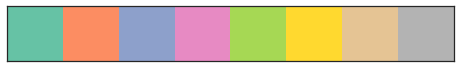

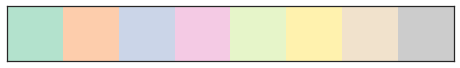

In [148]:
# Define cluster palette
sns.set(style='white')
palette = sns.color_palette('Set2', n)
pale_palette = sns.color_palette('Pastel2', n)
sns.palplot(palette)
sns.palplot(pale_palette)

<Figure size 432x288 with 0 Axes>

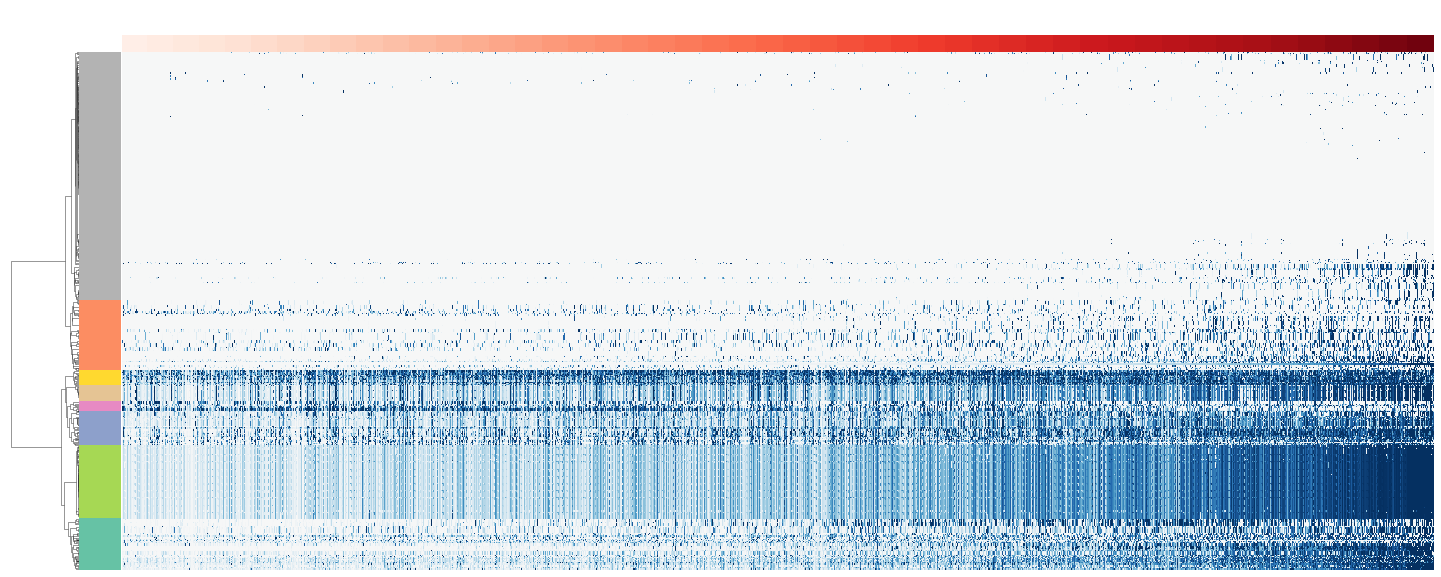

In [172]:
# Plot clustermap of normalized absolute fluxes
sns.set(font_scale=0.5)

f = plt.figure()

# df = sol_norm_df.sample(frac=1e-3, axis=1)
df = sol_norm_df

# cols = np.random.choice(df.columns, 1000)
cols = df.columns
col_order = pred_df.loc[cols][pred_df.loc[cols].o2_in > 0].sort_values(by=['j', 'i']).index

tol = 1e-6
rows = (df > tol).any(1)
# rows = df.index

row_colors = [palette[clusters[i]] for i in np.where(rows)[0]]
col_colors = [sns.color_palette('Reds', len(set(pred_df.j)))[i] for i in pred_df.loc[col_order].j]

g = sns.clustermap(df.loc[rows, col_order],
                   cmap='RdBu', 
                   center=0, 
                   robust=False, 
                   yticklabels=0, 
                   xticklabels=0, 
                   col_cluster=False, 
                   row_cluster=True, 
                   col_colors=col_colors, 
                   row_colors=row_colors, 
                   method='ward', 
                   figsize=(20, 8), 
                   dendrogram_ratio=5e-2, 
                   colors_ratio=3e-2)
g.ax_cbar.set_visible(False)

g.savefig(join(plot_dir, 'o2_clustermap.png'), bbox_inches='tight')

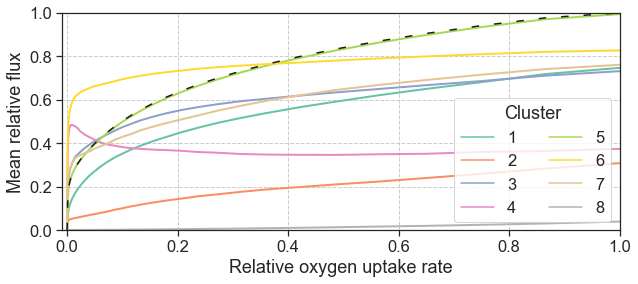

In [166]:
# Plot mean flux for each cluster

sns.set(style='ticks', font_scale=1.5)
f = plt.figure()

ax = sns.lineplot(x=melt_df.o2_in_rel, y=melt_df.flux_rel, ci=None, hue=melt_df.cluster, palette=palette, linewidth=2)
df = melt_df[melt_df.reaction == 'Biomass']
ax = sns.lineplot(x=df.o2_in_rel, y=df.flux_rel, ci=None, color='k', linestyle=(0, (5, 10)))
# ax.legend().set_visible(False)

plt.xlim(-0.01, 1)
plt.ylim(0, 1)
plt.xlabel('Relative oxygen uptake rate')
plt.ylabel('Mean relative flux')
plt.grid(True, ls='--')
plt.legend(title='Cluster', ncol=2).set_visible(True)

# for i in set(clusters):
#     x = pred_df.o2_in_rel
#     for c in np.where(clusters == i)[0]:
#         y = sol_norm_df.iloc[:, c]
#         ax = sns.lineplot(x=x, y=y, ci=False, color=pale_palette[i], alpha=1e-2, zorder=0)
        
f.set_size_inches(10, 4)
f.savefig(join(plot_dir, 'o2_clusters_mean.svg'), bbox_inches='tight')

In [157]:
# Get genes associated with each cluster
genes = defaultdict(set)
for i in set(clusters):
    for x in list(sol_norm_df.index[np.where(clusters == i)[0]]):
        try:
            genes[i] |= set(g.id for g in model.reactions.get_by_id(x).genes)
        except KeyError:
            continue

In [158]:
# Run g:Profiler (requires internet connection)
gp_dfs = {}
for x, g in genes.items():
    if not g:
        continue
    gp = GProfiler(return_dataframe=True)
    gp_dfs[x] = gp.profile(organism='ssalar', query=list(g), background=[g.id for g in model.genes])
gp_dfs[0]

source      native                                               name  \
0    KEGG  KEGG:00640                              Propanoate metabolism   
1      HP  HP:0011008                                   Temporal pattern   
2      HP  HP:0000738                                     Hallucinations   
3      HP  HP:0001250                                            Seizure   
4      HP  HP:0410066          Increased level of hippuric acid in urine   
5      HP  HP:0001332                                           Dystonia   
6      HP  HP:0002019                                       Constipation   
7      HP  HP:0003112      Abnormal circulating amino acid concentration   
8      HP  HP:0002060                       Abnormal cerebral morphology   
9      HP  HP:0100547                Abnormality of forebrain morphology   
10     HP  HP:0033107  Abnormal circulating proteinogenic amino acid ...   
11     HP  HP:0002017                                Nausea and vomiting   
12     HP  HP:0001608                           Abnormality of the voice   
13     HP  HP:0012443                    Abnormality of brain morphology   
14     HP  HP:0002197                          Generalized-onset seizure   
15     HP  HP:0004372                    Reduced consciousness/confusion   
16     HP  HP:0000751                                Personality changes   
17     HP  HP:0012402  Increased urine alpha-ketoglutarate concentration   
18     HP  HP:0008344         Elevated plasma branched chain amino acids   
19     HP  HP:0100314                          Cerebral inclusion bodies   
20   KEGG  KEGG:00280         Valine, leucine and isoleucine degradation   
21     HP  HP:0033354                    Abnormal urine metabolite level   
22     HP  HP:0001259                                               Coma   
23     HP  HP:0002011   Morphological central nervous system abnormality   
24     HP  HP:0012759                     Neurodevelopmental abnormality   
25  GO:MF  GO:0030170                        pyridoxal phosphate binding   
26  GO:MF  GO:0070279                                 vitamin B6 binding   
27     HP  HP:0011446              Abnormality of higher mental function   
28     HP  HP:0000708                             Behavioral abnormality   
29     HP  HP:0001254                                           Lethargy   
30     HP  HP:0033100  Increased proteinogenic amino acid level in urine   
31     HP  HP:0031980               Abnormal urine carboxylic acid level   
32     HP  HP:0003745                                           Sporadic   
33     HP  HP:0003110                   Abnormality of urine homeostasis   
34     HP  HP:0002353                                    EEG abnormality   
35     HP  HP:0100751                                Esophageal neoplasm   
36     HP  HP:0100315                                        Lewy bodies   
37  GO:BP  GO:0006101                          citrate metabolic process   
38     HP  HP:0045007               Abnormal substantia nigra morphology   
39     HP  HP:0002418                 Abnormality of midbrain morphology   
40     HP  HP:0002529            Neuronal loss in central nervous system   
41     HP  HP:0031908                                       Micrographia   
42     HP  HP:0012288                          Neoplasm of head and neck   
43     HP  HP:0011960                           Substantia nigra gliosis   
44     HP  HP:0007311                       Short stepped shuffling gait   
45     HP  HP:0033099        Increased serine family amino acid in urine   
46     HP  HP:0003108                                    Hyperglycinuria   
47     HP  HP:0011458                                  Abdominal symptom   
48     HP  HP:0004354  Abnormal circulating carboxylic acid concentra...   
49     HP  HP:0030178  Abnormality of central nervous system electrop...   
50   KEGG  KEGG:00430                 Taurine and hypotaurine metabolism   
51     HP  HP:0000494                     Downslant

In [159]:
# Get enriched KEGG pathways
alpha = 0.05
sig_df = pd.DataFrame()
for x, df in gp_dfs.items():
    df = df[(df['source'] == 'KEGG') & (df['p_value'] < alpha)].copy()
    df['cluster'] = x + 1
    sig_df = sig_df.append(df)
sig_df.head()

source      native                                        name  \
0    KEGG  KEGG:00640                       Propanoate metabolism   
20   KEGG  KEGG:00280  Valine, leucine and isoleucine degradation   
50   KEGG  KEGG:00430          Taurine and hypotaurine metabolism   
0    KEGG  KEGG:00280  Valine, leucine and isoleucine degradation   
5    KEGG  KEGG:00310                          Lysine degradation   

         p_value  significant                                 description  \
0   1.260866e-06         True                       Propanoate metabolism   
20  1.469994e-03         True  Valine, leucine and isoleucine degradation   
50  2.615643e-02         True          Taurine and hypotaurine metabolism   
0   5.113353e-24         True  Valine, leucine and isoleucine degradation   
5   3.775094e-07         True                          Lysine degradation   

    term_size  query_size  intersection_size  effective_domain_size  \
0          52          77                 21                    944   
20         72          77                 21                    944   
50         12          77                  8                    944   
0          72         126                 48                    944   
5          30         126                 20                    944   

    precision    recall    query       parents  cluster  
0    0.272727  0.403846  query_1  [KEGG:00000]        1  
20   0.272727  0.291667  query_1  [KEGG:00000]        1  
50   0.103896  0.666667  query_1  [KEGG:00000]        1  
0    0.380952  0.666667  query_1  [KEGG:00000]        2  
5    0.158730  0.666667  query_1  [KEGG:00000]        2

In [160]:
# Remove pathways outside model scope
for x in ['xenobiotics', 'drug']:
    sig_df = sig_df[~sig_df.description.str.lower().str.contains(x)]
sig_df.head()

source      native                                        name  \
0    KEGG  KEGG:00640                       Propanoate metabolism   
20   KEGG  KEGG:00280  Valine, leucine and isoleucine degradation   
50   KEGG  KEGG:00430          Taurine and hypotaurine metabolism   
0    KEGG  KEGG:00280  Valine, leucine and isoleucine degradation   
5    KEGG  KEGG:00310                          Lysine degradation   

         p_value  significant                                 description  \
0   1.260866e-06         True                       Propanoate metabolism   
20  1.469994e-03         True  Valine, leucine and isoleucine degradation   
50  2.615643e-02         True          Taurine and hypotaurine metabolism   
0   5.113353e-24         True  Valine, leucine and isoleucine degradation   
5   3.775094e-07         True                          Lysine degradation   

    term_size  query_size  intersection_size  effective_domain_size  \
0          52          77                 21                    944   
20         72          77                 21                    944   
50         12          77                  8                    944   
0          72         126                 48                    944   
5          30         126                 20                    944   

    precision    recall    query       parents  cluster  
0    0.272727  0.403846  query_1  [KEGG:00000]        1  
20   0.272727  0.291667  query_1  [KEGG:00000]        1  
50   0.103896  0.666667  query_1  [KEGG:00000]        1  
0    0.380952  0.666667  query_1  [KEGG:00000]        2  
5    0.158730  0.666667  query_1  [KEGG:00000]        2

In [161]:
# Abbreviate amino acids
d = {'Alanine': 'Ala', 'aspartate': 'Asp', 'glutamate': 'Glu', 'Tyrosine': 'Tyr', 'Valine': 'Val', ' leucine': ' Leu', 'isoleucine': 'Ile', 'Lysine': 'Lys', 'Arginine': 'Arg', 'proline': 'Pro', 'Phenylalanine': 'Phe', 'tyrosine': 'Tyr', 'tryptophan': 'Trp', 'Tryptophan': 'Trp', 'Glyoxylate and d': 'D', 'Histidine': 'His', 'beta-': 'β-'}
for x, y in d.items():
    sig_df.description = sig_df.description.str.replace(x, y)

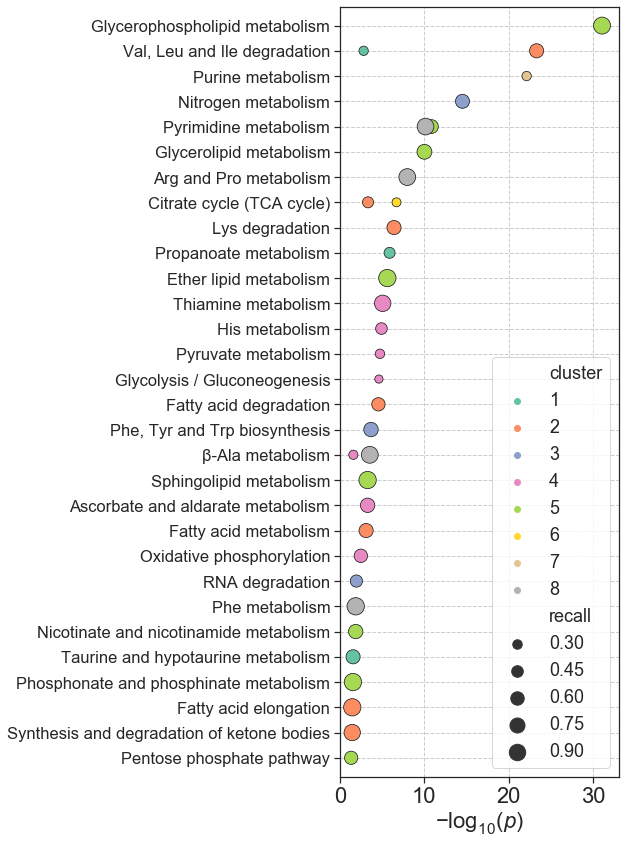

In [171]:
# Plot enriched pathways

# palette = sns.color_palette('Set2', n)

sns.set(style='ticks', font_scale=1.5)
f = plt.figure()

df = sig_df.sort_values(by='p_value', ascending=True)

s = 300 * df.recall
smin = 0
sizes = smin + int(s.min()), smin + int(s.max())

ax = sns.scatterplot(y=df.description, x=-np.log10(df.p_value), size=df.recall, sizes=sizes, hue=df.cluster, palette=palette, lw=0.5, ec='k', zorder=10, alpha=1)

plt.xlabel('$-$log$_{10}$($p$)', fontsize=22)
plt.xticks(fontsize=22)
plt.ylabel('')
plt.xlim(0, 33)
plt.ylim(len(df) - 4.25, -0.75)
plt.grid(True, ls='--', axis='both')

h, l = ax.get_legend_handles_labels()
plt.legend(h, l,loc='lower right', fontsize=18).set_visible(True)

f.set_size_inches(5, len(df) / 2.4)
f.savefig(join(plot_dir, 'o2_cluster_enrichment.svg'), bbox_inches='tight')

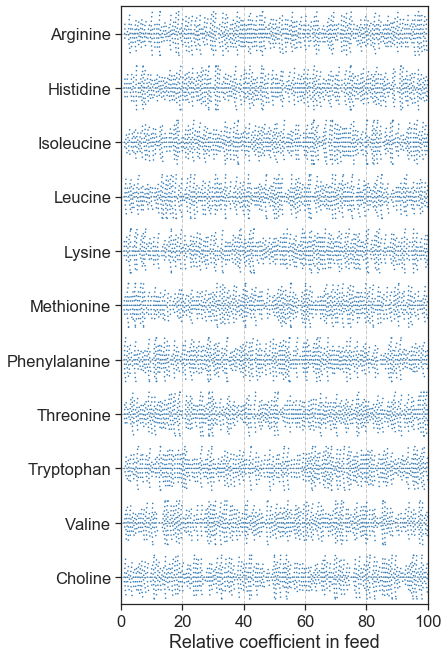

In [104]:
# Plot randomly sampled feed coefficients (conditions)
sns.set(style='ticks', font_scale=1.5)
f = plt.figure()

precursors = ['arg__L', 'his__L', 'ile__L', 'leu__L', 'lys__L', 'met__L', 'phe__L', 'thr__L', 'trp__L', 'val__L', 'chol']
tl = [model.reactions.get_by_id('EX_' + x + '_e').reactants[0].name.replace('L-', '').split(' ')[0] for x in precursors]
ylim = [-0.5, len(precursors) - 0.5]

df = cond_df
# ax = sns.stripplot(y=df.met, x=df.c, color='#377eb8', order=reversed(precursors), jitter=0.4, size=2)
ax = sns.swarmplot(y=df.met, x=df.c, color='#377eb8', size=1.6, order=reversed(precursors))
# plt.plot([100] * 2, ylim, c='k', ls='--')
# plt.plot([1] * 2, ylim, c='k', ls='--')
# plt.plot([101 / 2] * 2, ylim, c='k', ls='--')
plt.grid(True, ls='--')

ax.set_yticklabels(reversed(tl), rotation=0)
plt.xlim(0, 100)
plt.ylim(ylim)
plt.ylabel('')
plt.xlabel('Relative coefficient in feed')

f.set_size_inches(5.5, 11)
f.savefig(join(plot_dir, 'o2_cond.svg'), bbox_inches='tight')

In [105]:
# Correlate coefficients of feed metabolites
d = defaultdict(dict)
df = cond_df.sort_values(by='i')
for x1, x2 in combinations(set(df.met), 2):
    r, p = pearsonr(df[df.met == x1].c, df[df.met == x2].c)
    d[x1][x2] = d[x2][x1] = r
corr_df = pd.DataFrame(d).fillna(1)
corr_df

thr__L    lys__L    val__L      chol    leu__L    met__L    trp__L  \
lys__L -0.026212  1.000000  0.015391  0.016546  0.001598  0.015537  0.043848   
val__L -0.012751  0.015391  1.000000  0.006757 -0.014811 -0.063837  0.020005   
chol   -0.052657  0.016546  0.006757  1.000000 -0.033475  0.032064 -0.012707   
leu__L -0.018721  0.001598 -0.014811 -0.033475  1.000000 -0.002223  0.031702   
met__L  0.052972  0.015537 -0.063837  0.032064 -0.002223  1.000000  0.053118   
trp__L  0.046416  0.043848  0.020005 -0.012707  0.031702  0.053118  1.000000   
ile__L  0.026787 -0.001943  0.004891 -0.071848  0.000283  0.000335  0.024774   
phe__L  0.033463  0.010782  0.003916 -0.006301 -0.006083  0.021377 -0.068707   
arg__L -0.025136 -0.003028 -0.007894 -0.007605  0.009579  0.002224  0.037027   
his__L -0.041943 -0.036508  0.009531  0.027205  0.032249 -0.002558 -0.004854   
thr__L  1.000000 -0.026212 -0.012751 -0.052657 -0.018721  0.052972  0.046416   

          ile__L    phe__L    arg__L    his__L  
lys__L -0.001943  0.010782 -0.003028 -0.036508  
val__L  0.004891  0.003916 -0.007894  0.009531  
chol   -0.071848 -0.006301 -0.007605  0.027205  
leu__L  0.000283 -0.006083  0.009579  0.032249  
met__L  0.000335  0.021377  0.002224 -0.002558  
trp__L  0.024774 -0.068707  0.037027 -0.004854  
ile__L  1.000000  0.000226 -0.010383 -0.082204  
phe__L  0.000226  1.000000 -0.010453 -0.079486  
arg__L -0.010383 -0.010453  1.000000 -0.053820  
his__L -0.082204 -0.079486 -0.053820  1.000000  
thr__L  0.026787  0.033463 -0.025136 -0.041943

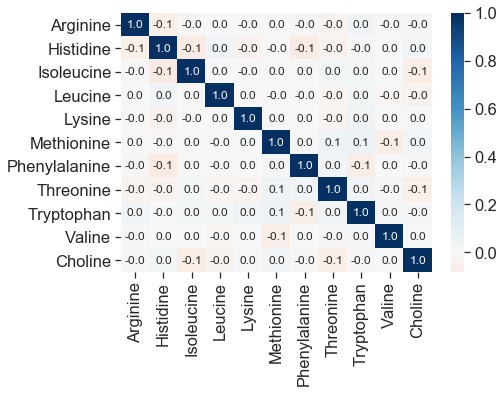

In [106]:
# Correlation heatmap
f = plt.figure()
ax = f.add_axes((0.28, 0.4, 0.9, 0.9))
sns.heatmap(corr_df.loc[precursors, precursors], cmap='RdBu', annot=True, 
                 fmt='.1f', center=0, annot_kws={"size":12}, ax=ax)
ax.set_xticklabels(tl)
ax.set_yticklabels(tl)
f.savefig(join(plot_dir, 'o2_cond_heatmap.svg'), bbox_inches='tight')

In [177]:
# Melt bound data frame
df = bound_df.melt(id_vars=['i', 'reaction'], value_vars=['lb', 'ub'], var_name='bound', value_name='b')
df.head()

i reaction bound          b
0  0     HMNO    lb   0.000000
1  0      PGL    lb   0.000000
2  0      GND    lb   0.000000
3  0   AACOAT    lb   0.000000
4  0    r0450    lb -17.548061

c:\users\ovoy\envs\salarecon\lib\site-packages\pandas\core\series.py:679 RuntimeWarning: invalid value encountered in log10


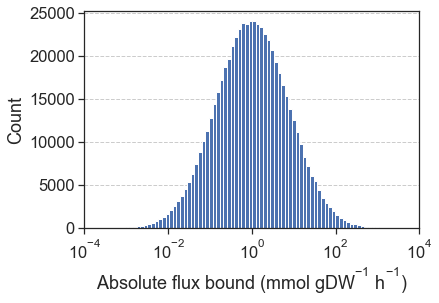

In [181]:
# Plot distribution of sampled bounds
f = plt.figure()
x = df[(df.b.abs() > 0)].b
ax = sns.histplot(x, bins=100, alpha=1, log_scale=True)
# plt.xscale('log')
plt.xlim(1e-4, 1e4)
plt.xlabel('Absolute flux bound (mmol gDW$^{-1}$ h$^{-1}$)')
plt.grid(True, axis='y', ls='--')
f.set_size_inches(6, 4)
f.savefig(join(plot_dir, 'o2_bounds.pdf'), bbox_inches='tight')

In [178]:
# Correlate sampled flux bounds
d = defaultdict(dict)
df = df[(df.b.abs() > 0)]

for x1, df1 in df.groupby(['reaction', 'bound']):
    for x2, df2 in df.groupby(['reaction', 'bound']):
        if x1 != x2 and not d[x1].get(x2, False):
            r, p = pearsonr(np.log10(df1.b.abs()), np.log10(df2.b.abs()))
            d[x1][x2] = d[x2][x1] = r
corr_df = pd.DataFrame(d).fillna(1)
corr_df.head()

1PPDCRp  2AMADPTm              2MCITt             2OBUTtm  \
                   ub        lb        ub        lb        ub        lb   
2AMADPTm lb -0.056245  1.000000  0.023528 -0.014069  0.025545 -0.010417   
         ub -0.018272  0.023528  1.000000  0.027024 -0.027558 -0.018201   
2MCITt   lb  0.008746 -0.014069  0.027024  1.000000  0.005975  0.001955   
         ub  0.065947  0.025545 -0.027558  0.005975  1.000000  0.021521   
2OBUTtm  lb  0.020348 -0.010417 -0.018201  0.001955  0.021521  1.000000   

                      2OXOADOXm 2OXOADPTm            ...     r1995     r1999  \
                   ub        ub        lb        ub  ...        ub        ub   
2AMADPTm lb -0.059599 -0.014264 -0.022268 -0.039270  ...  0.090519 -0.018438   
         ub -0.030809  0.018971  0.030877  0.030296  ...  0.030036 -0.021980   
2MCITt   lb  0.012213 -0.005206 -0.034735  0.031728  ...  0.009312  0.017816   
         ub  0.019279  0.006844  0.032193  0.027685  ...  0.009793  0.036654   
2OBUTtm  lb  0.029301 -0.020135  0.003751  0.006306  ...  0.002396  0.015814   

                r2000     r2008     r2009     r2011     r2015     r2016  \
                   ub        ub        ub        ub        ub        ub   
2AMADPTm lb  0.029629 -0.001530  0.010739  0.012022 -0.003276  0.005708   
         ub -0.034756  0.047977 -0.032124  0.013190 -0.008467  0.021076   
2MCITt   lb  0.038238  0.012853  0.041251 -0.004106 -0.002577 -0.009332   
         ub  0.014291  0.000936  0.015279 -0.002075 -0.026251 -0.004983   
2OBUTtm  lb  0.035042 -0.026489 -0.007085  0.042115 -0.002812 -0.068374   

                r2539            
                   lb        ub  
2AMADPTm lb  0.014573 -0.078101  
         ub  0.029216 -0.055113  
2MCITt   lb  0.012838  0.002152  
         ub -0.037332  0.035703  
2OBUTtm  lb -0.015150 -0.017296  

[5 rows x 870 columns]

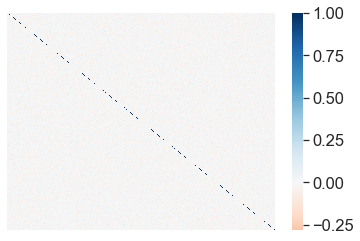

In [561]:
# Correlation heatmap
f = plt.figure()
corr_df = corr_df.sort_index(0).sort_index(1)
ax = sns.heatmap(corr_df, cmap='RdBu', annot=False, fmt='.1f', center=0, xticklabels=0, yticklabels=0)
ax.set_xlabel('')
ax.set_ylabel('')
f.savefig(join(plot_dir, 'o2_bounds_heatmap.png'), bbox_inches='tight', dpi=600)

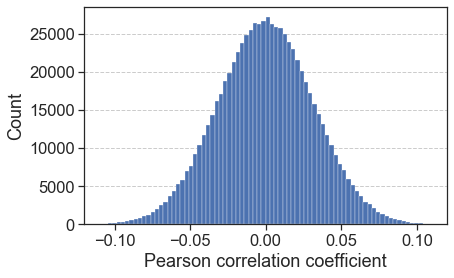

In [182]:
# Plot distribution of sampled correlation coefficients
f = plt.figure()
x = np.array([r for l in corr_df.values.tolist() for r in l ])
x = x[x < 1]
sns.histplot(x, bins=100, alpha=1)
plt.xlim(-0.12, 0.12)
plt.xlabel('Pearson correlation coefficient')
plt.grid(True, axis='y', ls='--')
f.set_size_inches(6.5, 4)
f.savefig(join(plot_dir, 'o2_bounds_corr.pdf'), bbox_inches='tight')

In [7]:
precursors = [model.metabolites.get_by_id(x + '_e')
              for x in ['arg__L', 'his__L', 'ile__L', 'leu__L', 'lys__L', 'met__L', 'phe__L', 'thr__L', 'trp__L', 'val__L', 'chol']]

In [59]:
df = sol_df
tol = 1e-6

df = df[set(['Biomass']) | set(r.id for r in model.boundary) - set('EX_' + x.id for x in precursors)]
df = (df.T / df.Biomass.abs()).T.fillna(0)
df = df.loc[:, (df > tol).any()]
# df[df == np.inf] = 0
df['o2_in_rel'] = pred_df.o2_in_rel
df = df.melt(var_name='reaction', value_name='flux_rel', id_vars='o2_in_rel').dropna()
df.loc[~df.reaction.isin(set(['EX_' + x + '_e' for x in ('co2', 'nh4', 'urea')])), 'reaction'] = 'Other'
df = df[df.flux_rel != np.inf]
df

o2_in_rel reaction  flux_rel
0          0.00000    Other  0.000000
1          0.00100    Other  0.000000
2          0.00115    Other  0.000000
3          0.00133    Other  0.000000
4          0.00154    Other  0.000000
...            ...      ...       ...
1899995    0.56234    Other  7.648539
1899996    0.64938    Other  7.288478
1899997    0.74989    Other  6.703010
1899998    0.86596    Other  5.084522
1899999    1.00000    Other  5.652261

[1899988 rows x 3 columns]

c:\users\ovoy\envs\salarecon\lib\site-packages\numpy\lib\function_base.py:4009 RuntimeWarning: invalid value encountered in subtract


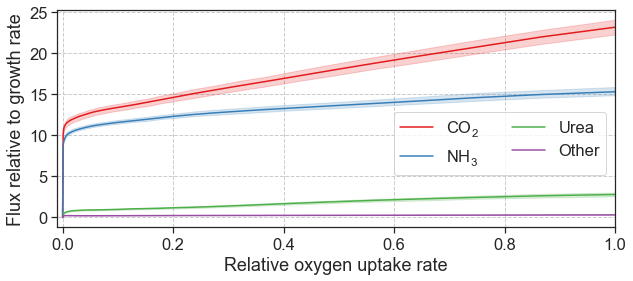

In [73]:
sns.set(style='ticks', font_scale=1.5)
f = plt.figure()

ax = sns.lineplot(x='o2_in_rel', y='flux_rel', hue='reaction', data=df, ci=95, hue_order=sorted(set(df.reaction)), palette='Set1')

# plt.yscale('log')
# plt.xscale('log')
# ax.legend(loc=(1.1, 0))
plt.xlim(-0.01, 1)
plt.xlabel('Relative oxygen uptake rate')
plt.ylabel('Flux relative to growth rate')
plt.grid(True, ls='--')
plt.legend(['CO$_2$', 'NH$_3$', 'Urea', 'Other'], ncol=2, loc=(0.603, 0.24)).set_visible(True)

# for i in set(clusters):
#     x = pred_df.o2_in_rel
#     for c in np.where(clusters == i)[0]:
#         y = sol_norm_df.iloc[:, c]
#         ax = sns.lineplot(x=x, y=y, ci=False, color=pale_palette[i], alpha=1e-2, zorder=0)
        
f.set_size_inches(10, 4)
f.savefig(join(plot_dir, 'o2_secretion.png'), bbox_inches='tight')